<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']

positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)  # (10000, 4, 2, 5), (10000, 1, 2, 5), (10000, 5, 1)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features) # (2000, 4, 2, 5), (2000, 1, 2, 5), (2000, 5, 1)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)    # (2000, 4, 2, 5), (2000, 1, 2, 5), (2000, 5, 1)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0]

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

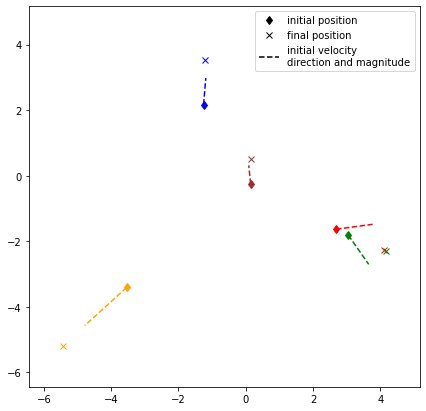

In [7]:
random_idx = np.random.randint(0, 10000)  # 随机生成一个simulation id, plot这个simulation的particals的运动轨迹。每个simulation包含了t=0,0.5,1,1.5这4个时间点的particle的位置
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [8]:
def print_simulation(sim=0):
  print(f"Simulation id: {sim}")
  for particle in range(5):
    print("-" * 50)
    print(f"Particle {particle}:")
    p = [positions_train[sim, t, (0, 1), particle] for t in range(4)]
    v = velocities_train[sim, 0, (0, 1), particle]
    c = charges_train[sim, particle, 0]
    print(f"initial speed: {v}")
    print(f"charge: {c}")
    for t, pos in enumerate(p):
      print(f"t = {t*0.5}, position: {pos}")

print_simulation(42)

Simulation id: 42
--------------------------------------------------
Particle 0:
initial speed: [-0.65809419  0.83992187]
charge: 1.0
t = 0.0, position: [-1.76624107  0.93973633]
t = 0.5, position: [-2.08163222  1.3930285 ]
t = 1.0, position: [-2.37825743  1.90932565]
t = 1.5, position: [-2.69592681  2.46719546]
--------------------------------------------------
Particle 1:
initial speed: [-0.40620729  0.16026227]
charge: -1.0
t = 0.0, position: [-0.20959475  1.86319488]
t = 0.5, position: [-0.41693119  1.91713519]
t = 1.0, position: [-0.64291873  1.93309039]
t = 1.5, position: [-0.89414468  1.93751838]
--------------------------------------------------
Particle 2:
initial speed: [0.02911909 0.29003103]
charge: 1.0
t = 0.0, position: [1.63593336 0.83207924]
t = 0.5, position: [1.63487281 0.96496278]
t = 1.0, position: [1.60443825 1.0748045 ]
t = 1.5, position: [1.54730075 1.16200246]
--------------------------------------------------
Particle 3:
initial speed: [ 0.28402364 -0.24784824]

In [9]:
velocity_train_data = torch.tensor(velocities_train.reshape(-1, 10), dtype=torch.float) # (sim_dix) -> [x1, x2, x3, x4, x5, y1, y2, y3, y4, y5]
charge_train_data = torch.tensor(charges_train.reshape(charges_train.shape[0], -1), dtype=torch.int)  # (sim_dix) -> [x1, x2, x3, x4, x5, y1, y2, y3, y4, y5]
position_train_data = torch.tensor(positions_train.reshape(positions_train.shape[0], -1, 10), dtype=torch.float)  # (sim_dix, time) -> -> [x1, x2, x3, x4, x5, y1, y2, y3, y4, y5]

velocity_vali_data = torch.tensor(velocities_valid.reshape(-1, 10), dtype=torch.float)
charge_vali_data = torch.tensor(charges_valid.reshape(charges_valid.shape[0], -1), dtype=torch.int)
position_vali_data = torch.tensor(positions_valid.reshape(positions_valid.shape[0], -1, 10), dtype=torch.float)

velocity_test_data = torch.tensor(velocities_test.reshape(-1, 10), dtype=torch.float)
charge_test_data = torch.tensor(charges_test.reshape(charges_test.shape[0], -1), dtype=torch.int)
position_test_data = torch.tensor(positions_test.reshape(positions_test.shape[0], -1, 10), dtype=torch.float)

num_positions = velocity_train_data.shape[-1]
num_particles = charge_train_data.shape[-1]
num_times = positions_train.shape[1]

train_dataset = TensorDataset(velocity_train_data, charge_train_data, position_train_data)
val_dataset = TensorDataset(velocity_vali_data, charge_vali_data, position_vali_data)
test_dataset = TensorDataset(velocity_test_data, charge_test_data, position_test_data)

train_dataloader = DataLoader(train_dataset, batch_size=100)  # 10000 = 100 * 100
val_dataloader = DataLoader(val_dataset, batch_size=100)      # 2000 = 20 * 100
test_dataloader = DataLoader(test_dataset, batch_size=100)    # 2000 = 20 * 100

# (sim_idx) -> charge[c1, c2, c3, c4, c5]
# (sim_idx) -> velocity[x1, x2, x3, x4, x5, y1, y2, y3, y4, y5]
# (sim_idx, time) -> position[x1, x2, x3, x4, x5, y1, y2, y3, y4, y5]

In [10]:
print("Training set:")
print(f"velocity: {velocity_train_data.shape}\ncharge: {charge_train_data.shape}\nposition: {position_vali_data.shape}\n")

print("Each batch in training set")
for v, c, p in train_dataloader:
  print(f"velocity: {v.shape}\ncharge: {c.shape}\nposition: {p.shape}")
  break

Training set:
velocity: torch.Size([10000, 10])
charge: torch.Size([10000, 5])
position: torch.Size([2000, 4, 10])

Each batch in training set
velocity: torch.Size([100, 10])
charge: torch.Size([100, 5])
position: torch.Size([100, 4, 10])


# Model Implementation

<image src="https://cdn.jsdelivr.net/gh/ruichen-ing/images@master/RNN_a2.png" width="700" />


In [11]:
from torch import nn

class PreprocessMLP(nn.Module):
    """
    Preprocess velocity, charge, position input and map them to an embedding by a MLP.
    The embedding is the output of MLP and input of LSTM.
    """

    def __init__(self, in_dim, out_dim=32):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, out_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.mlp(x)

In [12]:
# test PreprocessMLP
block = PreprocessMLP(5, 32)
temp_data = torch.randn(50, 5)  # batch_size = 50
temp_data = block(temp_data)
print(temp_data.shape)
temp_data = temp_data.unsqueeze(1)
print(temp_data.shape)

torch.Size([50, 32])
torch.Size([50, 1, 32])


In [13]:
class ParticlePositionPredictor(nn.Module):
    
    def __init__(self,
                 num_positions=num_positions,
                 num_particles=num_particles,
                 embed_dim=32, 
                 hidden_dim=64, 
                 num_layers=1,
                 hidden_dense_dim=64,
                 dense_dropout=0.4):

        '''
        embed_dim: embedding size of velocity, charge, position = output size of MLP block = input size of LSTM
        hidden_dim: size of LSTM hidden layer
        num_layers: number of hidden layers in each LSTM
        hidden_dense_dim: size of the dense layer after LSTM
        dense_dropout: rate for dropout layer after the dense layer
        '''
        
        super(ParticlePositionPredictor, self).__init__()

        self.embed_dim = embed_dim
        self.num_positions = num_positions
        self.num_particles = num_particles

        self.speedMLP = PreprocessMLP(num_positions, self.embed_dim)
        self.chargeMLP = PreprocessMLP(num_particles, self.embed_dim)
        self.positionMLP = PreprocessMLP(num_positions, self.embed_dim)
        
        # Process data with LSTM
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)  # batch_size, hidden_dim

        # Fully connected layer after RNN output, to learn more complex relations
        self.f0 = nn.Linear(hidden_dim, hidden_dense_dim)
        self.relu = nn.ReLU()

        # Dropout to regularize this dense layer
        self.drop = nn.Dropout(p=dense_dropout)

        # Map to a categorical distribution of length num_words
        self.f1 = nn.Linear(hidden_dense_dim, num_positions)
        
        # No need of an additional activation layer, because it is actually a regression task, and the prediction can be any value
        # Loss function
        self.criterion = nn.MSELoss()
        
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.001, weight_decay=0.05, momentum=0.9)
        self.optimizer = torch.optim.Adam(self.parameters())  # weight_decay insreases loss dramatically,
    
    def forward(self, velocities, charges, positions):
        """
        Forward pass of trainable model. It predicts each next word
        in the descriptive sentence as if the previous word was correct
        by substitution of the ground truth word for the previous word.

        Input:
        charges: (batch_size, num_particles) num_particles = 5
        velocities: (batch_size, num_positions) num_positions = 10 -> 5x + 5y
        posiitons: (batch_size, num_positions) num_positions = 10

        Outputs:
        output: (batch_size, num_times + 1, num_positions), num_times = 4 , num_positions = 10
        """

        velocity_vector = self.speedMLP(velocities)
        velocity_vector = velocity_vector.unsqueeze(1) # add a dimension to tensor such that it matches the model
        charge_vector = self.chargeMLP(charges.type(torch.FloatTensor))
        charge_vector = charge_vector.unsqueeze(1)
        # position_embedding = (lambda x: self.positionMLP(x))(positions)
        position_embedding = self.positionMLP(positions)

        # Remove the position of the last time point, as it is only used for true prediction value. [start:end], [:-1] without the last one
        position_embedding = position_embedding[:, :-1,:]   # batch_size, time, embedding

        # Concatenate all our inputs -> velocity, charge and position
        concat_embeddings = torch.cat([velocity_vector, charge_vector, position_embedding], dim=1) #(batch_size, max_seq_len_in_batch+1, embedding_dim)
        
        # Feed packed input sequence to rnn
        # return: output, (hn, cn)
        rnn_output, _ = self.rnn(concat_embeddings)  #(batch_size, max_seq_len_in_batch+1, embedding_dim)

        # To further process, put the data through a dense layer
        output = self.f0(rnn_output)

        # apply activation
        output = self.relu(output)

        # and apply dropout!
        output = self.drop(output)

        # Map rnn output to vector of length num_words
        output = self.f1(output) #(batch_size, num_time + 1, 10), 10 -> 5 positions(x, y)

        # we remove the first two outputs as it corresponds to initial speed and charge
        # we only need the prediction on t = 0.5, 1.0, 1.5. We do not need to predict for position on t = 0
        output = output[:, 2:] #(batch_size, num_time -1, 10)
        return output
        

# Model Training

In [14]:
import time

def train(dataloader):
    model.train()
    total_correct, total_count = 0, 0

    for charges, velocities, positions in dataloader:
        # padded_word_idcs: padded caption tokens(still textual, not index yet)

        charges = charges.to(device)
        velocities = velocities.to(device)
        positions = positions.to(device)
        
        model.optimizer.zero_grad()

        # prediction on t = 0.5, 1.0, 1.5
        y_pred = model(charges, velocities, positions)
        
        # y_true: crop the true positions, as we only need the last 3 positions
        y_true = positions[:, 1:, :]
        loss = model.criterion(y_pred, y_true)
        
        loss.backward()
        
        # set a gradient threshold to avoid exploding gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        model.optimizer.step()
        
        # TODO: how to evaluate the performance/accuracy of the model? distance is not a good metric to express performance?
        # total_correct += (y_pred.argmax(2) == padded_word_idcs).sum().item()
        # total_count += padded_word_idcs.size(0) * 35

    return loss.item()

def evaluate(dataloader):
    model.eval()
    total_correct, total_count = 0, 0

    with torch.no_grad():
        for charges, velocities, positions in dataloader:
            
            charges = charges.to(device)
            velocities = velocities.to(device)
            positions = positions.to(device)

            y_pred = model(charges, velocities, positions)
            y_true = positions[:, 1:, :]
            loss = model.criterion(y_pred, y_true)

            # total_correct += (y_pred.argmax(2) == padded_word_idcs).sum().item()
            # total_count += padded_word_idcs.size(0) * 35

    return loss.item()

In [15]:
EPOCHS = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters

model = ParticlePositionPredictor(
                 embed_dim=32, 
                 hidden_dim=64, # output size of MLP, input size of LSTM, embedding size of velocity, charge, position
                 num_layers=1,
                 hidden_dense_dim=64,
                 dense_dropout=0).to(device)  # dropout increases training loss dramatically such that validation loss and test loss are lower than training loss! Thus, dropout is removed.

train_loss, cali_train_loss, val_loss, test_loss = [], [], [], []
# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss.append(train(train_dataloader))
    # cali_train_loss.append(evaluate(train_dataloader))
    val_loss.append(evaluate(val_dataloader))
    test_loss.append(evaluate(test_dataloader))
    
    print('-' * 80)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss: {:5.3f}    '
          'validation loss: {:5.3f}'.format(epoch,
                                     time.time() - epoch_start_time, 
                                     train_loss[-1],
                                    #  cali_train_loss[-1],
                                     val_loss[-1],
                                     test_loss[-1]))
    print('-' * 80)

--------------------------------------------------------------------------------
| end of epoch   1 | time:  2.24s | train loss: 5.099    validation loss: 5.576
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   2 | time:  2.09s | train loss: 2.393    validation loss: 2.821
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   3 | time:  2.23s | train loss: 1.575    validation loss: 1.721
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
| end of epoch   4 | time:  2.33s | train loss: 1.253    validation loss: 1.366
--------------------------------------------------------------------------------
--------------------------------

Train loss: 0.09994333982467651
Validation loss: 0.13098964095115662
Test loss: 0.17952381074428558


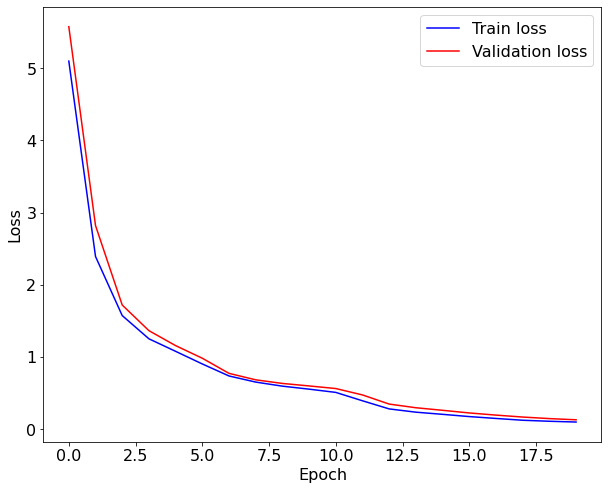

In [16]:
def PlotLoss():
  f, ax = plt.subplots(1,1, figsize=(10,8))

  fnt=16
  ax.plot(train_loss, color='blue', label='Train loss')
  # ax.plot(cali_train_loss, color='green', label='Calibrated train loss')
  ax.plot(val_loss, color='red', label='Validation loss')
  # ax.plot(test_loss, color='green', label='Test loss')
  ax.legend(fontsize=fnt)
  ax.tick_params(axis='both', labelsize=fnt)

  ax.set_xlabel("Epoch", fontsize=fnt)
  ax.set_ylabel("Loss", fontsize=fnt);

PlotLoss()
test_loss = evaluate(test_dataloader)
print(f"Train loss: {train_loss[-1]}\nValidation loss: {val_loss[-1]}\nTest loss: {test_loss}")

In [17]:
def get_predicted_positions(dataloader):
  '''
  get the predicted positions per particle per simulation at t = 0.5, 1.0, 1.5
  '''
  model.eval()
  init = []
  latter = []
  pred = []

  with torch.no_grad():
    for charges, velocities, positions in dataloader:
      charges = charges.to(device)
      velocities = velocities.to(device)
      positions = positions.to(device)

      y_pred = model(charges, velocities, positions)
      y_pred = y_pred.cpu().detach().numpy()   # (100, 3, 10)
      first = positions[:, 0, :].unsqueeze(1).cpu().detach().numpy() #(100, 1, 10)
      init.extend(first)
      latter.extend(y_pred)

  for i in range(len(init)):
    pred.extend(np.concatenate((init[i], latter[i])))
    
  return np.array(pred).reshape(-1, num_times, 2, num_particles)

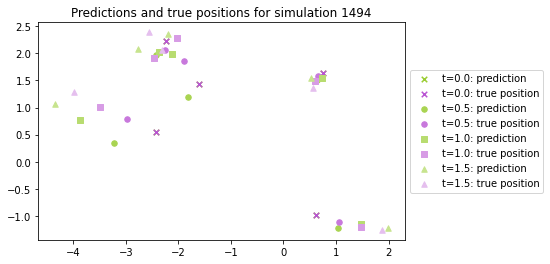

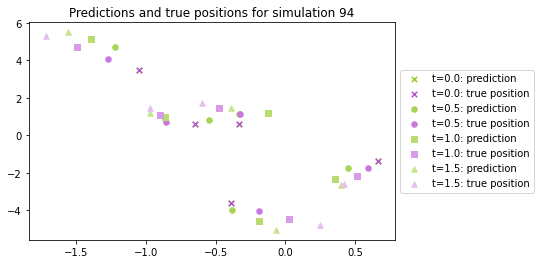

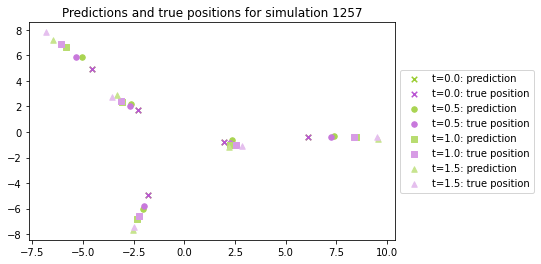

In [18]:
import matplotlib.colors as mc
import colorsys
import random

def adjust_lightness(color, amount=0.5):
    '''
    helper function to change scatter color
    '''
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

pred_test_positions = get_predicted_positions(test_dataloader)

markers = ["x", "o", "s", "^", "d"]

def plot_prediction(sim_idx, pred_positions, true_positions):
  for id in sim_idx:
    pred = pred_positions[id]   # (4, 2, 5)
    true = true_positions[id]   # (4, 2, 5)

    pred_position_particle = []
    true_position_particle = []
    for p_id in range(num_particles):
      pred_position_particle.append(pred[:,:,p_id])
      true_position_particle.append(true[:,:,p_id])

    fig, ax = plt.subplots(1,1, figsize=(10, 4))
    for time_dix in range(num_times):

      x_pred = pred[time_dix, 0]
      y_pred = pred[time_dix, 1]
      x_true = true[time_dix, 0]
      y_true = true[time_dix, 1]

      plt.scatter(x_pred, y_pred, s=30, color=adjust_lightness('yellowgreen', 1+time_dix*0.15), marker=markers[time_dix], label=f't={time_dix*0.5}: prediction')
      plt.scatter(x_true, y_true, s=30, color=adjust_lightness('mediumorchid', 1+time_dix*0.15), marker=markers[time_dix], label=f't={time_dix*0.5}: true position')
      ax.set_title(f"Predictions and true positions for simulation {id}")

      box = ax.get_position()
      ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
      ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  
  plt.show()

# plot 3 random simulations
idx = random.sample(range(positions_test.shape[0]), 3)
plot_prediction(idx, pred_test_positions, positions_test)

In [19]:
# import matplotlib.colors as mc
# import colorsys
# import random

# def adjust_lightness(color, amount=0.5):
#     '''
#     helper function to change scatter color
#     '''
#     import matplotlib.colors as mc
#     import colorsys
#     try:
#         c = mc.cnames[color]
#     except:
#         c = color
#     c = colorsys.rgb_to_hls(*mc.to_rgb(c))
#     return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# pred_test_positions = get_predicted_positions(test_dataloader)

# markers = ["x", "o", "s", "^", "d"]
# colors = ["yellowgreen", "darkmagenta", "royalblue", "darkgreen", "teal", "mediumorchid", "chocolate", "coral", "firebrick", "goldenrod"]

# def plot_prediction(sim_idx, pred_positions, true_positions):
#   for id in sim_idx:
#     pred = pred_positions[id]   # (4, 2, 5)
#     true = true_positions[id]   # (4, 2, 5)

#     fig, ax = plt.subplots(1,1, figsize=(6, 4))
#     for p_id in range(num_particles):
#       for time_dix in range(num_times):

#         x_pred = pred[:,:,p_id][time_dix, 0]
#         y_pred = pred[:,:,p_id][time_dix, 1]
#         x_true = true[:,:,p_id][time_dix, 0]
#         y_true = true[:,:,p_id][time_dix, 1]

#         plt.scatter(x_pred, y_pred, s=30, color=adjust_lightness(colors[p_id], 1+time_dix*0.2), marker=markers[time_dix], label=f't={time_dix*0.5}: prediction')
#         plt.scatter(x_true, y_true, s=30, color=adjust_lightness(colors[p_id + 5], 1+time_dix*0.15), marker=markers[time_dix], label=f't={time_dix*0.5}: true position')
#         ax.set_title(f"Predictions and true positions for simulation {id}")

#         # box = ax.get_position()
#         # ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
#         # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  
#   plt.show()

# # plot 3 random simulations
# idx = random.sample(range(positions_test.shape[0]), 3)
# plot_prediction(idx, pred_test_positions, positions_test)

# Evaluation

In the above section, we obtain the predicted positions by feeding the positions at all time points $t\in\{0, 0.5, 1.0, 1.5\}$. Then, the loss is calculated by comparing the predictions and the true values. This approach is the same as how we treat validation set that we don't use the predicted position at the last time step to be the input position at next time step.

To better evaluate the model, in the following section we only feed the initial position of the particles and get the predicted positions at $t\in\{0.5, 1.0, 1.5\}$ with a greedy search method. That is, regarding output target position at each time step as the correct position, and putting it into the model as the start position for the next turn.

<image src="https://cdn.jsdelivr.net/gh/ruichen-ing/images@master/RNN_a2_decoder.png" width=700 />

In [20]:
class GreedySearchEvaluator():
    '''
    Greedy search to get the position at the next time point
    '''

    def __init__(self, init_positions, velocity, charge, model=model, num_times=num_times):
        self.trained_model = model
        self.num_times = num_times
        self.true_data = init_positions
        self.velocities = velocity
        self.charges = charge
        
    def evaluate(self):
        '''
        manually go through MLP and LSTM to get predictions by a greedy decode method
        intput: velocity, charge, init_positions(t = 0)
        output: predicted positions at t = 0.5, 1.0, 1.5
                return a list with size = 3, each element of list is a tensor with the size (dataset_dim, 1, num_positions)
                for test dataset, dataset_dim = 2000
        '''
        self.trained_model.train()
        
        with torch.no_grad():
            velocity_vector = self.trained_model.speedMLP(self.velocities)
            velocity_vector = velocity_vector.unsqueeze(1)

            charge_vector = self.trained_model.chargeMLP(self.charges.type(torch.FloatTensor))
            charge_vector = charge_vector.unsqueeze(1)

            # take our rnn cell in eval-mode: in case we use multiple layers with
            # dropout (not currently selected), we want to avoid using dropout in
            # the evaluation -> .eval() fixes this
            rnn_eval = self.trained_model.rnn.eval()

            # pass the first two time steps, i.e. velocity and charge 
            # We don't need the output but the hidden state. It will then be fed into time step for positions
            # hx: hidden state from the previous time step
            _, rnn_state = rnn_eval(input=velocity_vector, hx=None)
            _, rnn_state = rnn_eval(input=charge_vector, hx=rnn_state)

            pred_positions = []
            for t in range(self.num_times - 1):
                if t == 0:
                  # use the initial position to get the first position prediction
                  position_embedding = self.trained_model.positionMLP(self.true_data[:, 0, :])   # (batch_size, num_positions)
                  position_embedding = position_embedding.unsqueeze(1)    # (batch_size, 1, num_positions)
                else:
                  # last predicted position as next input
                  position_embedding = self.trained_model.positionMLP(pred_positions[-1])
                
                # Feed embedding of previous word into RNN 
                rnn_output_next_position, rnn_state = rnn_eval(input=position_embedding.to(device), hx=rnn_state)

                # feed output through dense
                rnn_output_next_position = self.trained_model.f0(rnn_output_next_position)
                rnn_output_next_position = self.trained_model.relu(rnn_output_next_position)

                # Map to num_positions entries which enables predicting next position of particles
                pred_next_position = self.trained_model.f1(rnn_output_next_position)
                
                # append next position to position list
                pred_positions.append(pred_next_position)

                self.pred = pred_positions


    def loss(self):
      '''
      calculate MSE loss by comparing predicted positions with true test positions
      '''
      greedy_pred_positions = torch.zeros(self.true_data.shape)

      for i in range(num_times):
        if i == 0:
          greedy_pred_positions[:, i, :] = self.true_data[:, 0, :]
        else:
          greedy_pred_positions[:, i, :] = self.pred[i - 1].reshape(-1, num_positions)
      
      loss_fn = nn.MSELoss()
      loss = [loss_fn(greedy_pred_positions[:, i, :], self.true_data[:, i, :]).item()
                for i in range(num_times)]
      loss.append(loss_fn(greedy_pred_positions, self.true_data).item())

      return greedy_pred_positions, loss

In [21]:
# input: initial speed, charge, initial position(t = 0)
evaluator = GreedySearchEvaluator(position_test_data, velocity_test_data, charge_test_data, model, num_times)
evaluator.evaluate()
pp, loss = evaluator.loss()

print("loss for test data")
for i in range(len(loss)):
  if i == len(loss) - 1:
    print(f"average: {loss[i]}")
  else:
    print(f"t={i*0.5}: {loss[i]}")

loss for test data
t=0.0: 0.0
t=0.5: 0.12839174270629883
t=1.0: 0.34810227155685425
t=1.5: 0.743708074092865
average: 0.3050505220890045


In [22]:
# compare the true position and the predicted position of a random simulation
idx = random.randint(0, position_test_data.shape[0] - 1)
print(f"Simulation {idx}:")
print("-" * 75)
print(f"true position:\n{position_test_data[idx, :, :]}")
print("-" * 75)
print(f"predicted position(greedy search):\n{pp[idx, :, :]}")

Simulation 991:
---------------------------------------------------------------------------
true position:
tensor([[ 2.0313, -0.8600, -0.1252, -0.7316,  1.9598, -1.3331, -0.0040, -0.2596,
          1.2728, -1.4340],
        [ 2.0844, -0.8455, -0.1843, -0.6176,  2.0679, -1.6866, -0.0633,  0.0655,
          1.4030, -1.5541],
        [ 2.2267, -0.3963, -0.7244, -0.4570,  2.0863, -1.9128,  0.1493,  0.1274,
          1.5247, -1.8017],
        [ 2.1127, -0.7384, -0.4698, -0.2990,  2.3603, -2.0601,  0.4688,  0.0683,
          1.6602, -2.1279]])
---------------------------------------------------------------------------
predicted position(greedy search):
tensor([[ 2.0313, -0.8600, -0.1252, -0.7316,  1.9598, -1.3331, -0.0040, -0.2596,
          1.2728, -1.4340],
        [ 2.2129, -0.9085,  0.1340, -0.8176,  2.6461, -1.0202,  0.0292, -0.0183,
          1.6386, -1.8122],
        [ 2.3797, -0.8533,  0.3400, -0.9965,  3.2305, -0.9227, -0.0491, -0.0477,
          1.9935, -2.3067],
        [ 2.5263, 

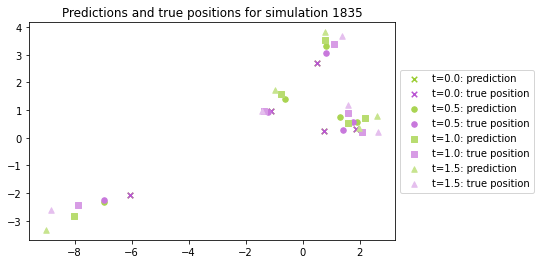

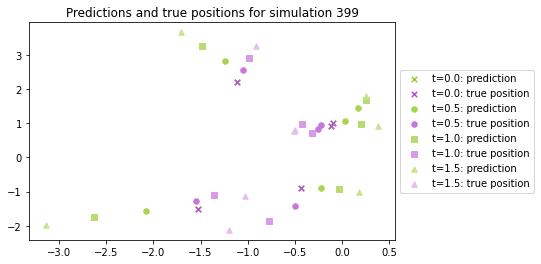

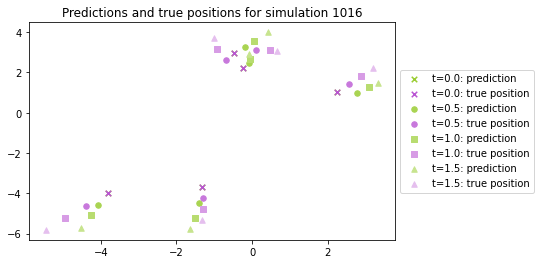

In [23]:
# plot 3 simulations(greedy decoder)
pp = pp.reshape(pp.shape[0], num_times, -1, num_particles)   # change the dimension to the same of positions_test
idx = random.sample(range(positions_test.shape[0]), 3)
plot_prediction(idx, pp, positions_test)